<a href="https://colab.research.google.com/github/CoryLaidlaw/fastai_tutorial_notes/blob/main/FastAI_Computer_Vision_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.vision.all import *

# Dog vs Cat

## Get Images

Using Oxford-IIIT  Pet Database

In [ ]:
path = untar_data(URLs.PETS)

In [ ]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/annotations'),Path('/root/.fastai/data/oxford-iiit-pet/images')]

get_image_files: fastai funct that grabs image files recursively in one folder

In [ ]:
files = get_image_files(path/"images")
len(files)

7390

## Labeling & Data Loaders

Dog files start lowercased, cats start uppercase. This allows for a simple label fuinction

In [ ]:
def label_func(f): return f[0].isupper()

Putting data into a dataloader object. from_name_func used since we have a funct using filenames for labels. Resizing to 224x224

In [ ]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

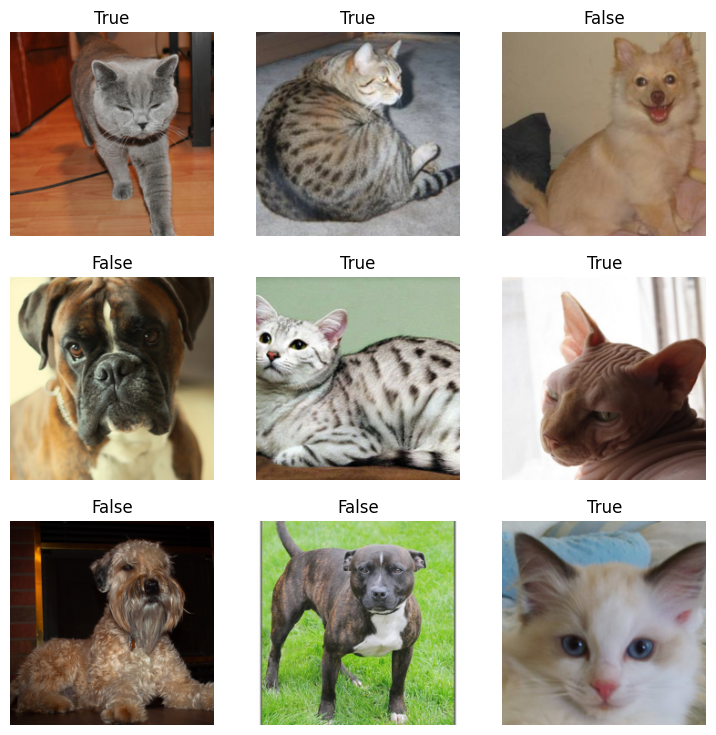

In [ ]:
dls.show_batch()

## Learner

Now we can create a learner that combines the data with a model. Since we are using a pre-existing model, we can use fine_tune

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 71.8MB/s]


Used to see a prediction for a new image

In [ ]:
learn.predict(files[0])

('False', tensor(0), tensor([1.0000e+00, 2.5567e-07]))

Seeing results from learning

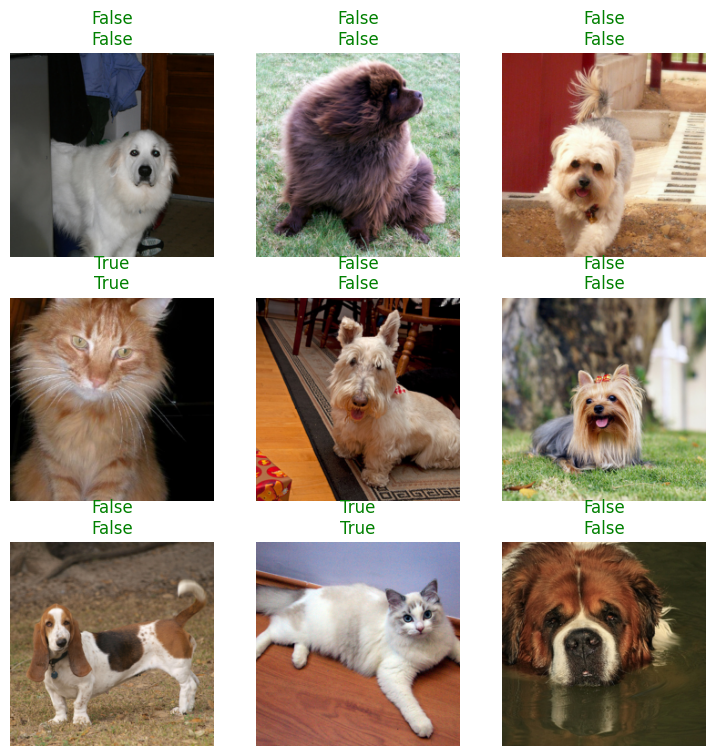

In [ ]:
learn.show_results()

# Classifying Breeds

## Labeling and Dataloader

Moving into classifying by breed

In [ ]:
files[0].name

'beagle_40.jpg'

Creating a pattern with Regular expressions that will allow us to extract the breed, which is everything before the last _ followerd by some digits

In [ ]:
pat = r'^(.*)_\d+.jpg'

using frome_name_re for extracting names using reg expressions

In [ ]:
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(224))

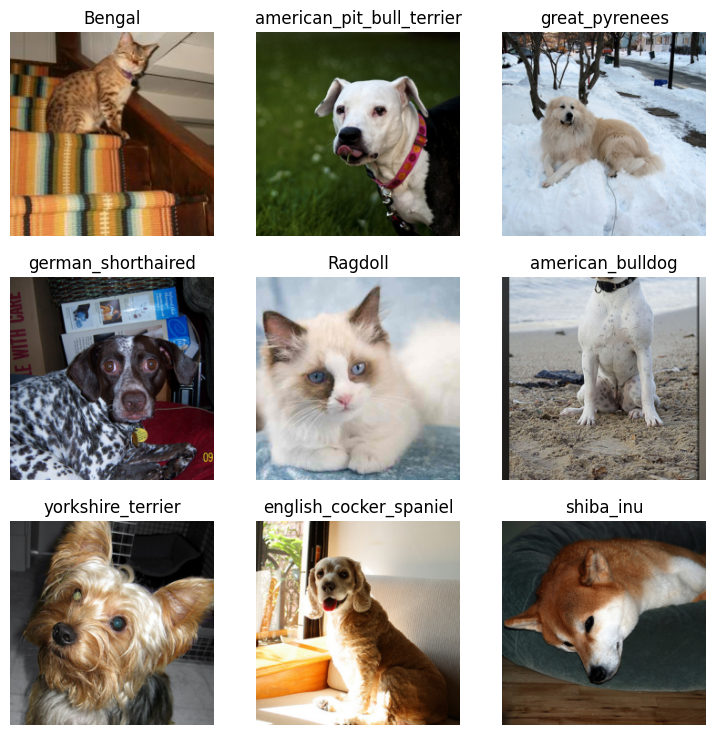

In [ ]:
dls.show_batch()

Since classifying by breed is a more complicated problem we are using a larger size before batching and then when batching we apply some transformations to vary the data

In [ ]:
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(460),
                                    batch_tfms=aug_transforms(size=224))

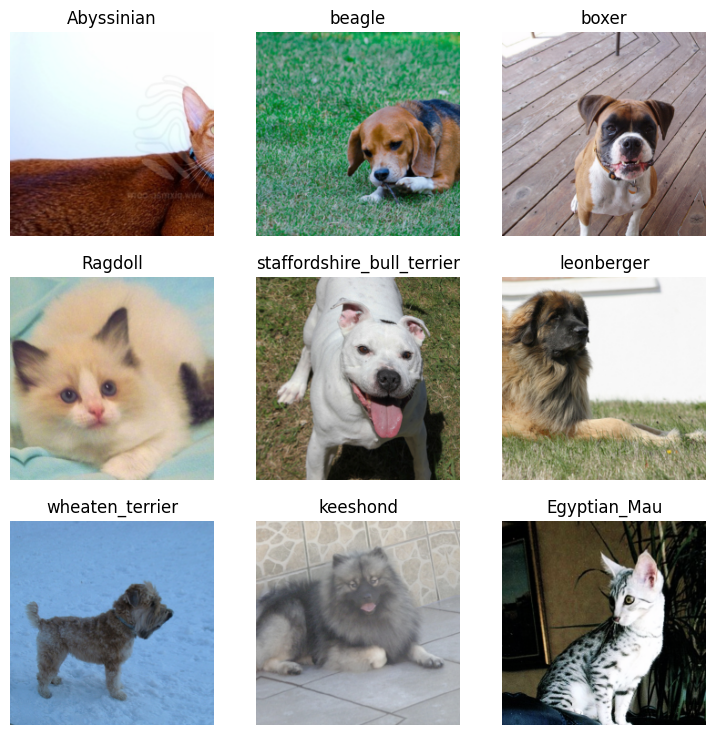

In [ ]:
dls.show_batch()

## Learner

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

Instead of using the default learning rate we can use learning rate finder to find the best one. This gives us valley algorithm for a suggestion by default and plots a graph.

SuggestedLRs(valley=0.0006918309954926372)

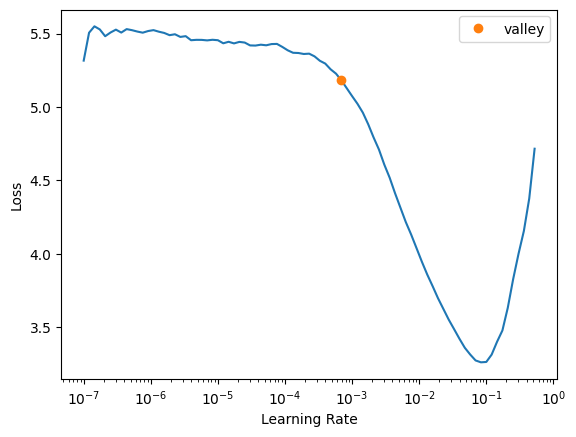

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(4, 0.0006918309954926372)

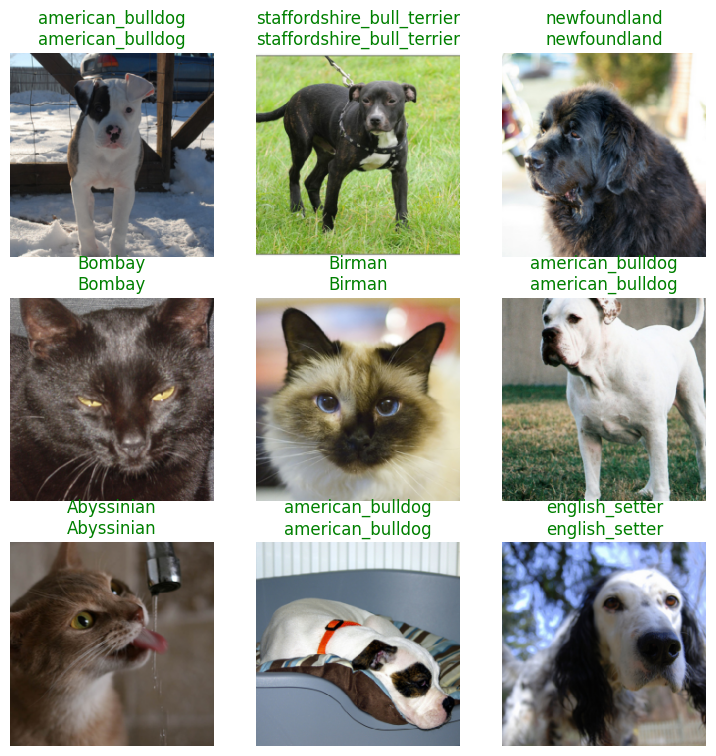

In [ ]:
learn.show_results()

Using interpertation object to show where model made the worst predictions

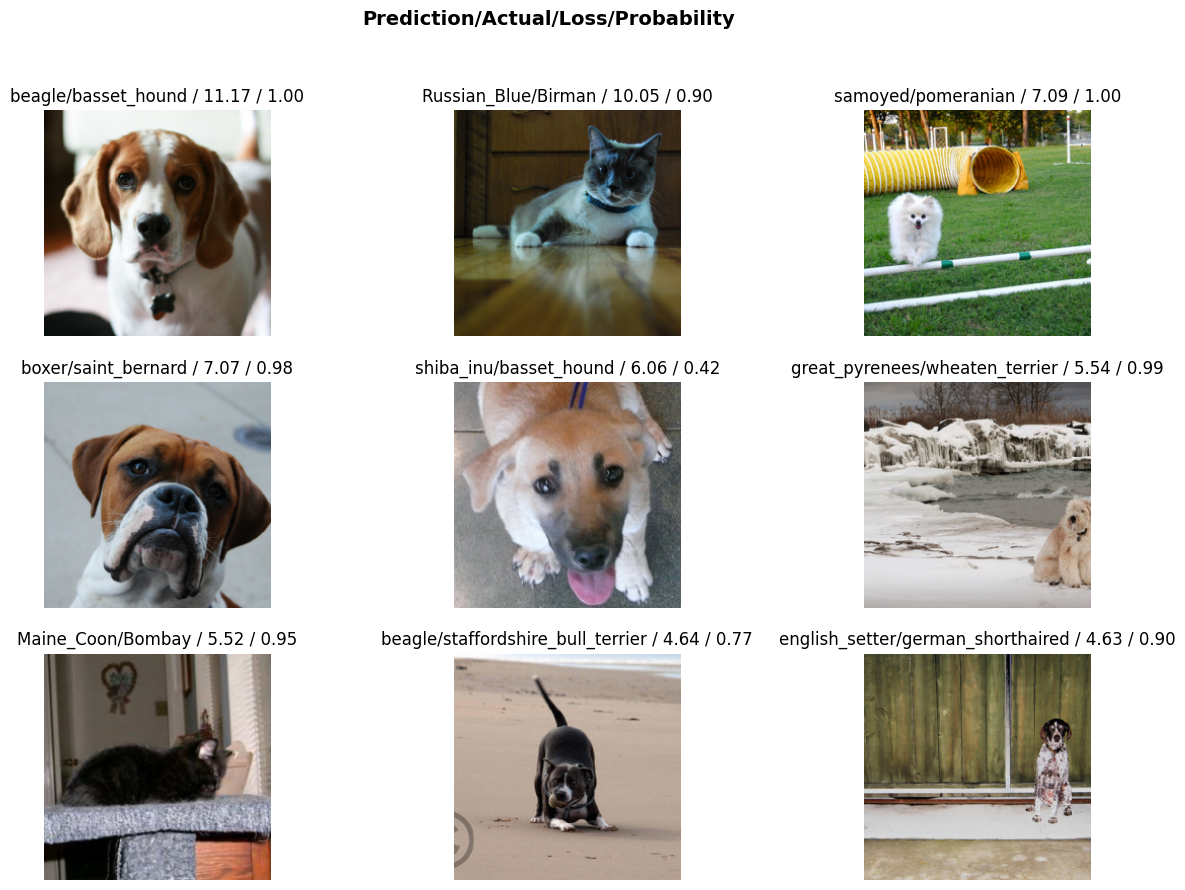

In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

# Multi-label Classification

## Get Images

Using Pascal Dataset. Images contains different kinds of objects and persons and images could have more then just one object or person, hence Multi-Label.

In [ ]:
path = untar_data(URLs.PASCAL_2007)
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/train.csv')]

## Labeling & Dataloader

train.csv contains labels for images

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

fname        labels  is_valid
0  000005.jpg         chair      True
1  000007.jpg           car      True
2  000009.jpg  horse person      True
3  000012.jpg           car     False
4  000016.jpg       bicycle      True

Using from_df to get label info from dataframe. Filename column and label column defaults to first and second column.

In [ ]:
dls = ImageDataLoaders.from_df(df, path, folder='train', valid_col='is_valid', label_delim=' ',
                               item_tfms=Resize(460), batch_tfms=aug_transforms(size=224))

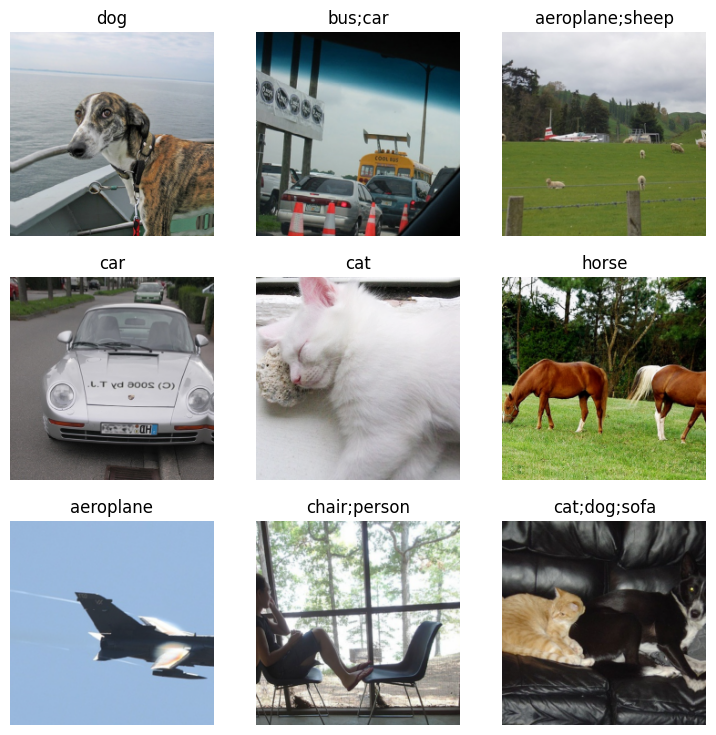

In [ ]:
dls.show_batch()

## Learner

error_rate metric will not work for multi-label, instead we use accuracy_thresh and F1ScoreMulti. Also changing default name for metrics.

In [ ]:
f1_macro = F1ScoreMulti(thresh=0.5, average='macro')
f1_macro.name = 'F1(macro)'
f1_samples = F1ScoreMulti(thresh=0.5, average='samples')
f1_samples.name = 'F1(samples)'
learn = vision_learner(dls, resnet50, metrics=[partial(accuracy_multi, thresh=0.5), f1_macro, f1_samples])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s]


Finding a good LR

SuggestedLRs(valley=0.001737800776027143)

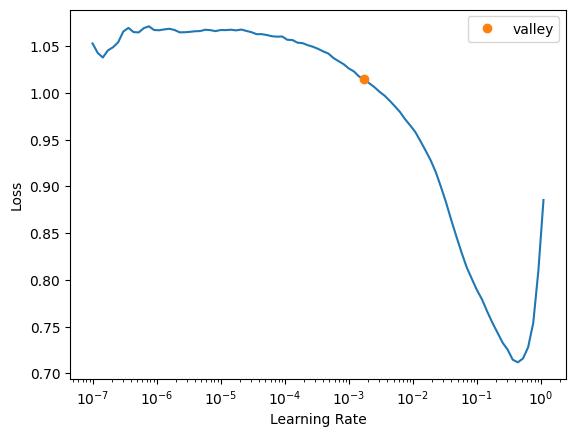

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(10, 0.0012022644514217973)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


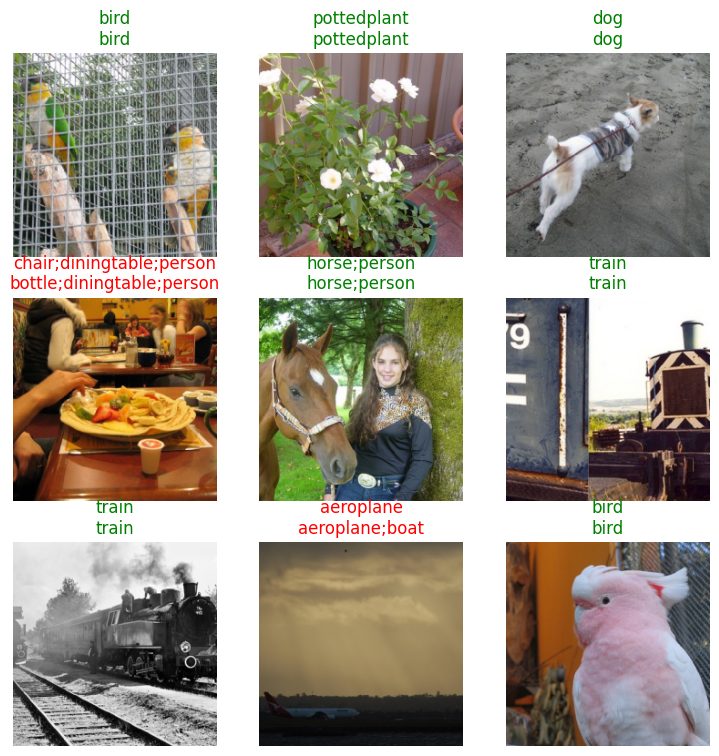

In [ ]:
learn.show_results()

In [ ]:
learn.predict(path/'train/000005.jpg')

((#2) ['chair','diningtable'],
 tensor([False, False, False, False, False, False, False, False,  True, False,
          True, False, False, False, False, False, False, False, False, False]),
 tensor([0.0202, 0.0329, 0.0291, 0.0495, 0.1086, 0.0474, 0.0100, 0.0134, 0.9915,
         0.0404, 0.7093, 0.0397, 0.0228, 0.0394, 0.1840, 0.1564, 0.0445, 0.3153,
         0.0297, 0.1459]))

Showing top losses

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


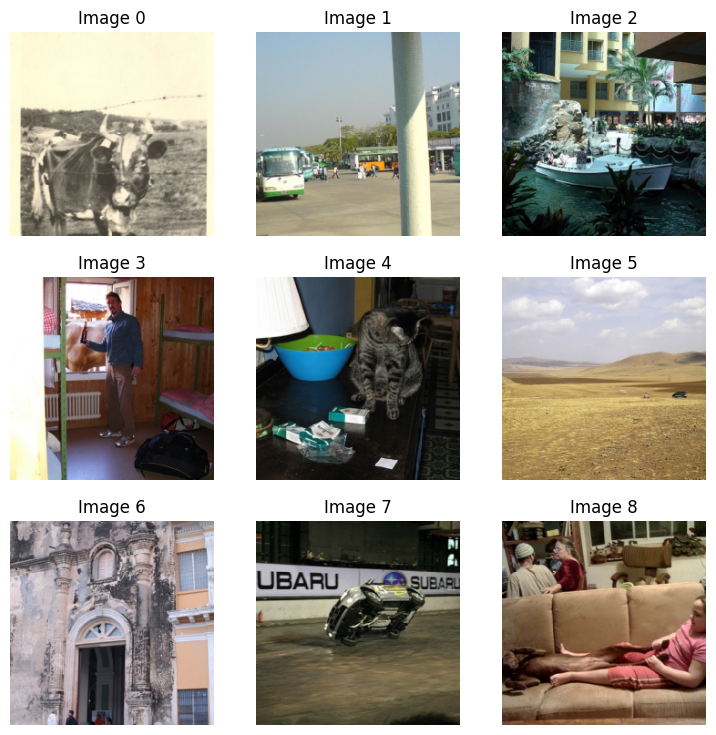

In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

# Segmentation

## Get Images

Using dataset containing images from dashcams. Each pixel is labeled as 'road, 'car, or 'pedestrian'

In [ ]:
path = untar_data(URLs.CAMVID_TINY)
path.ls()

(#3) [Path('/root/.fastai/data/camvid_tiny/codes.txt'),Path('/root/.fastai/data/camvid_tiny/labels'),Path('/root/.fastai/data/camvid_tiny/images')]

Codes file contains cooresponding integer to class. (Masks have and int value for each pixel)

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Labeling & Dataloader

Using get_image_files function to grab image names

In [ ]:
fnames = get_image_files(path/"images")
fnames[0]

Path('/root/.fastai/data/camvid_tiny/images/0016E5_08009.png')

Labels have base names with _P at the end, so we can define a label funct

In [ ]:
(path/"labels").ls()[0]

Path('/root/.fastai/data/camvid_tiny/labels/0016E5_06090_P.png')

In [ ]:
def label_func(fn): return path/"labels"/f"{fn.stem}_P{fn.suffix}"

Using SegmentationDataLoaders to account for segmentation problem, we don't need item_tfms to resize since images are all the same size

In [ ]:
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = fnames, label_func = label_func, codes = codes
)

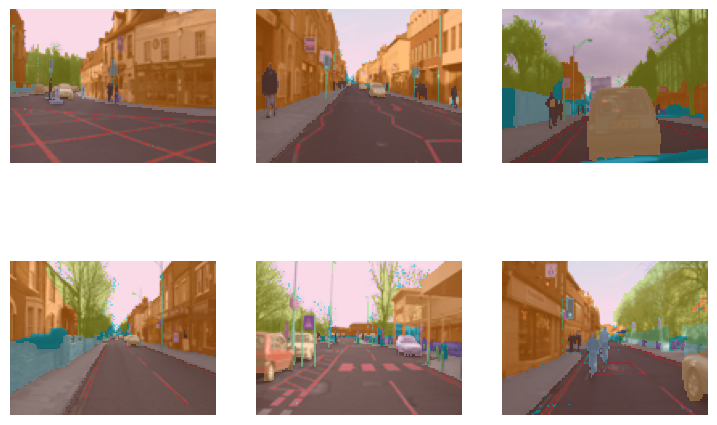

In [ ]:
dls.show_batch(max_n=6)

## Learner

For this problem a CNN won't work and we need to use an UNet

In [ ]:
learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 169MB/s]


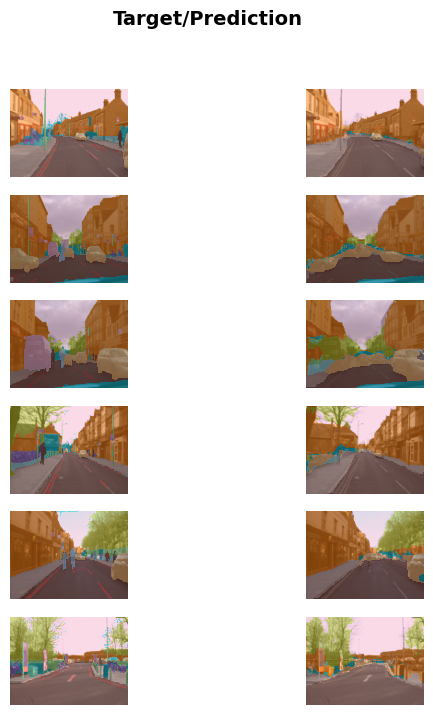

In [ ]:
learn.show_results(max_n=6, figsize=(7,8))

Showing top losses

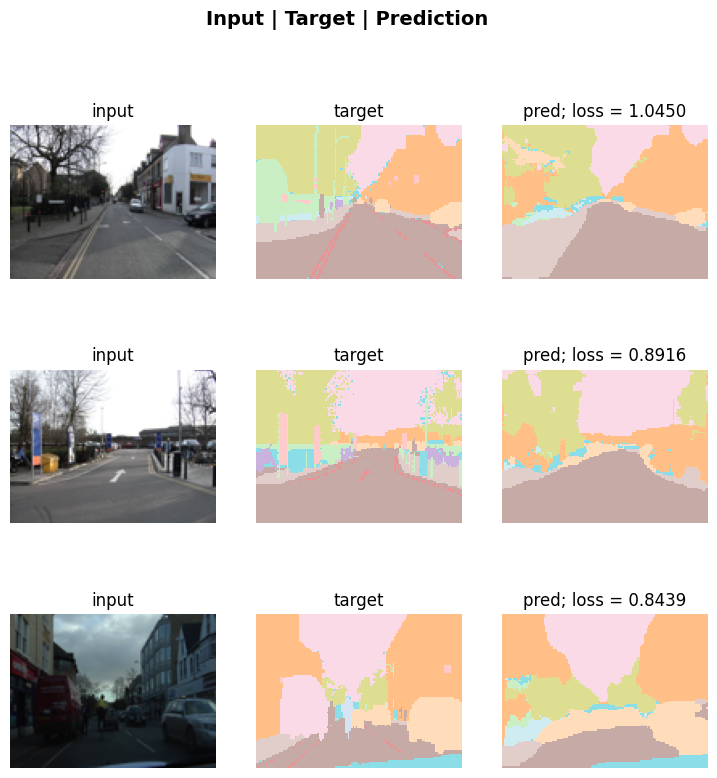

In [ ]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=3)